In [1]:
from pandas_datareader import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import save_image
from torch.optim import lr_scheduler


In [2]:
tickers  = ['SPY']

In [3]:
spy = data.DataReader(tickers, 
                       start='2011-1-1', 
                       end='2021-07-31', 
                       data_source='yahoo')['Close']

In [4]:
df1 = pd.DataFrame(spy)
df1.tail()

Symbols,SPY
Date,
2021-07-26,441.019989
2021-07-27,439.010010
2021-07-28,438.829987
2021-07-29,440.649994
2021-07-30,438.510010


In [5]:
df2 = df1.reset_index()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [7]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.12*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 30 # choose sequence length
x_train, y_train, x_test, y_test = split_data(df1, lookback)

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2316, 29, 1), (2316, 1), (316, 29, 1), (316, 1))

In [9]:
def scale():
    X_train = scaler.fit_transform(x_train.reshape(-1,x_train.shape[-1])).reshape(x_train.shape)
    X_test = scaler.transform(x_test.reshape(-1,x_test.shape[-1])).reshape(x_test.shape)
    Y_train = scaler.fit_transform(y_train)
    Y_test = scaler.transform(y_test)

    return [X_train, Y_train, X_test, Y_test]
X_train, Y_train, X_test, Y_test = scale()


In [10]:
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(Y_train).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([2316, 29, 1]),
 torch.Size([2316, 1]),
 torch.Size([316, 29, 1]),
 torch.Size([316, 1]))

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
input_size = 1
hidden_size = 32
num_layers = 3
output_size = 1
num_epochs = 200

In [14]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True,dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
model = GRU(input_dim=input_size, hidden_dim=hidden_size, output_dim=output_size, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [16]:
import time
hist = np.zeros(num_epochs)
t_hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):

    # make predictions
    model.train()
    scheduler.step()
    y_train_pred = model(x_train)
   # print(y_train_pred.shape)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
    
        y_test_pred = model(x_test)
        #print(y_test_pred.shape)
        loss_eval = criterion(y_test_pred, y_test)
        #print("Epoch ", t, "MSE: ", loss.item())
        t_hist[t] = loss_eval.item()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

C:\Users\pgsin\anaconda3\envs\deeplearner\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch  0 MSE:  0.19497598707675934
Epoch  1 MSE:  0.05791056901216507
Epoch  2 MSE:  0.10005606710910797
Epoch  3 MSE:  0.058893729001283646
Epoch  4 MSE:  0.05961592495441437
Epoch  5 MSE:  0.06726446002721786
Epoch  6 MSE:  0.05975406989455223
Epoch  7 MSE:  0.049345992505550385
Epoch  8 MSE:  0.044741515070199966
Epoch  9 MSE:  0.04571529105305672
Epoch  10 MSE:  0.041023578494787216
Epoch  11 MSE:  0.02997175045311451
Epoch  12 MSE:  0.020709292963147163
Epoch  13 MSE:  0.015160682611167431
Epoch  14 MSE:  0.006615115329623222
Epoch  15 MSE:  0.0020008685532957315
Epoch  16 MSE:  0.01691645383834839
Epoch  17 MSE:  0.010462777689099312
Epoch  18 MSE:  0.00904362928122282
Epoch  19 MSE:  0.003404888790100813
Epoch  20 MSE:  0.001270841807126999
Epoch  21 MSE:  0.003775689285248518
Epoch  22 MSE:  0.006396971642971039
Epoch  23 MSE:  0.006855627056211233
Epoch  24 MSE:  0.00627099210396409
Epoch  25 MSE:  0.006134538445621729
Epoch  26 MSE:  0.0060694520361721516
Epoch  27 MSE:  0.00

In [17]:
hist.min(), hist.max(), hist.mean(), hist.std()

(0.0006460564327426255,
 0.19497598707675934,
 0.005509876664436888,
 0.01887271656514338)

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))


In [19]:
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

C:\Users\pgsin\anaconda3\envs\deeplearner\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout, = ax.plot([], [], **kws)
C:\Users\pgsin\anaconda3\envs\deeplearner\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot([], [], **kws)
C:\Users\pgsin\anaconda3\envs\deeplearner\lib\site-packages\seaborn\relational.py:529: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot(x, y, **kws)
C:\Users\pgsin\anaconda3\envs\deeplearner\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout, = ax.plot

Text(0.5, 1.0, ' GRU Loss')

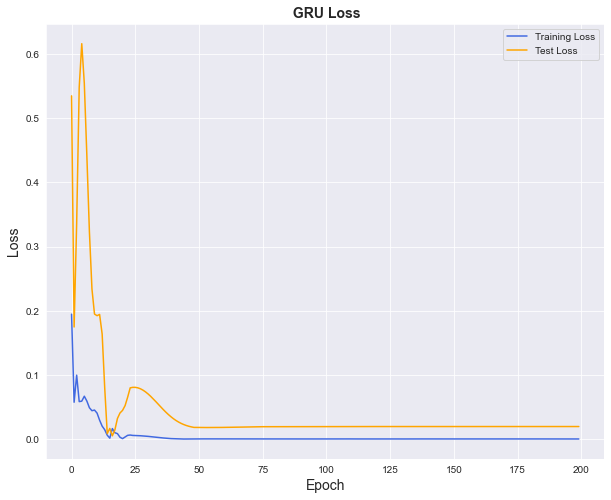

In [20]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure(figsize=(10,8))
#fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 3, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato', alpha=0.5)
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


ax = sns.lineplot(data=hist, color='royalblue',Label='Training Loss')
ax = sns.lineplot(data=t_hist, color='orange',Label='Test Loss')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title(" GRU Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)

# plt.subplot(1, 3, 3)
# ax = sns.lineplot(data=t_hist, color='royalblue')
# ax.set_xlabel("Epoch", size = 14)
# ax.set_ylabel("Loss", size = 14)
# ax.set_title("Test Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)



In [21]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)


# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 6.19 RMSE
Test Score: 32.38 RMSE


In [22]:
yt = pd.DataFrame(y_test_pred)
exp = pd.concat([predict, yt])
exp.to_csv('gru_pred_spy_covid.csv')

In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(df1)-1, :] = y_test_pred

originals = df1.SPY.values.reshape(-1,1)

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, originals, axis=1)

result = pd.DataFrame(predictions)
result = pd.concat([df2.Date, result], axis=1)
result.to_csv('GRU_predictions_covid.csv')	

In [24]:
error = []
for i in range(len(y_test_pred)):
    error.append(y_test_pred[i]-y_test[i])
error = np.array(error)

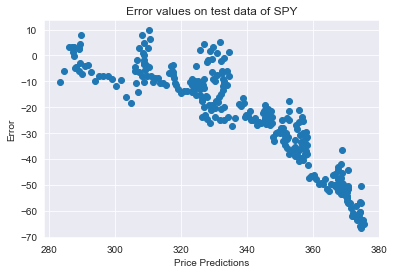

In [25]:
plt.scatter(y_test_pred, error)
plt.xlabel('Price Predictions')
plt.ylabel('Error')
plt.title('Error values on test data of SPY')
plt.show()

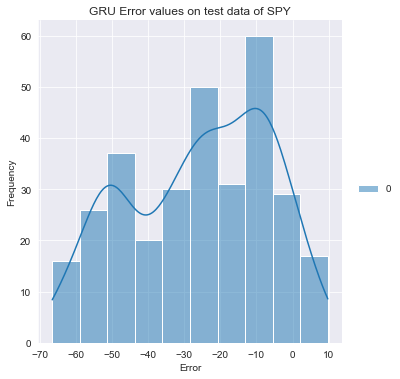

In [26]:
sns.displot(error, kde =True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('GRU Error values on test data of SPY')
plt.show()


In [27]:
error.mean()


-25.97074

In [28]:
error.max() - error.min()   

76.27826